## load STAR ESDM threshold counts (35C) and plot violin plots, maps, including countsxpopulation in hi SVI areas
## WORLDPOP in place of GPWv4 data

### load modules

In [1]:
# Import modules
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import netCDF4 as nc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cf
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu

#luke added for running on dcc
import os
import sys
#luke added for loading to make daily means and keeping track of time in loop
import time as tm
import xarray as xr
import xesmf as xe

print('done loading modules')

done loading modules


## define years of analysis, which experiment, etc.

In [3]:
years = np.arange(1950,2101,1)

experiment = 'ssp585'

t2m_threshs = [30, 35, 37, 38, 39]

thresh = 35 # define temperature threshold for plotting/analysis- 35C or 39C in the paper

var = 'tasmax'

variable = 'count_'+str(thresh)+'C'

print(variable)

#define SOVI cutoff
high_sovi_cutoff = 0.75
low_sovi_cutoff = 0.25


count_35C


## load regridded population data, SVI data, state boundaries
# Note using Worldpop as da_pop (default data used in rest of code)

In [4]:
datadir_pop_gpw = '/uufs/chpc.utah.edu/common/home/u6053495/linkscratch/data/conus_heat_data/'
fname_pop_gpw = 'gpw_v4_population_count_adjusted_to_2015_unwpp_country_totals_rev11_2020_nclimgrid_min.nc'
ds_pop_gpw = xr.open_dataset(datadir_pop_gpw + fname_pop_gpw)
da_pop_gpw = ds_pop_gpw['population'].where(ds_pop_gpw['population'] > 0)

datadir_pop = '/uufs/chpc.utah.edu/common/home/u6053495/linkscratch/data/conus_heat_data/'
fname_pop = 'usa_ppp_2020_UNadj_constrained_resample_sum_nclimgrid.nc'
ds_pop = xr.open_dataset(datadir_pop + fname_pop)
da_pop = ds_pop['population'].where(ds_pop['population'] > 0)
regridder_gpw_worldpopnclimgrid = xe.Regridder(da_pop, da_pop_gpw, "bilinear")
#regridder_gpw_worldpopnclimgrid.to_netcdf()
da_pop = regridder_gpw_worldpopnclimgrid(da_pop)
#np.log(da_pop).plot()
#plt.title('log of population (for plotting purposes)')

datadir_svi = '/uufs/chpc.utah.edu/common/home/u6053495/linkscratch/data/conus_heat_data/'
fname_svi = 'svi_2020_tract_overall_nclimgrid.nc'
ds_svi = xr.open_dataset(datadir_svi + fname_svi)
da_svi = ds_svi['svi']

datadir_states = '/uufs/chpc.utah.edu/common/home/u6053495/linkscratch/data/conus_heat_data/'
fname_states = 'State_ID_from_zhouCroppedForStates_nclimgrid.nc'
ds_states = xr.open_dataset(datadir_states + fname_states)
da_states = ds_states['ID']

# usc sovi
datadir_svi = '/uufs/chpc.utah.edu/common/home/u6053495/linkscratch/data/conus_heat_data/'
fname_svi = 'SoVI_2019.nc'
ds_sovi = xr.open_dataset(datadir_svi + fname_svi)
ds_sovi = ds_sovi.rename({'lon':'longitude','lat':'latitude'})
ds_sovi['longitude'] = ds_sovi['longitude'] + 360
da_sovi = ds_sovi['svi']
da_sovi = (da_sovi + 10)/20 #convert to same units as svi
regridder = xe.Regridder(da_sovi, da_svi, "bilinear")
#regridder_svi_sovi = regridder.to_netcdf()
da_sovi = regridder(da_sovi)#,'bilinear',weights='bilinear_598x1387_596x1385.nc')

## load dynamic worldpop population projections for testing impacts of increasing population

In [5]:
years_pop_ssps = np.arange(2020,2101,5)
datadir_popw = '/uufs/chpc.utah.edu/common/home/u6053495/linkscratch/data/conus_heat_data/ssp_pop_projections/'

ssp_pop = 'SSP5'

for yi,year in enumerate(years_pop_ssps):
    print(year)
    fname_popw = str(ssp_pop)+'_'+str(year)+'_cdf_nclimgrid.nc'
    ds_popw = xr.open_dataset(datadir_popw + fname_popw)
    time = pd.date_range(start=pd.to_datetime("1/1/"+str(year)), periods=1, freq='AS')
    ds_popw = ds_popw.expand_dims(time=time)
    da_popw = ds_popw['population'].where(ds_popw['population'] > 0)

    if yi == 0:
        popw_allyears = da_popw
    else:
        popw_allyears = xr.concat((popw_allyears,da_popw),dim='time')

#interpolate to annual from 5 yr increments
popw_allyears = popw_allyears.resample(time="1A").interpolate(kind="linear")

2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
2100


## load nclimgrid counts

In [6]:
path_data_nclimgrid = '/uufs/chpc.utah.edu/common/home/u6053495/linkscratch/data/conus_heat_data/'

ds_nclimgrid = xr.open_dataset(path_data_nclimgrid + 'nclimgrid_tmax_counts.exceed.30C_35C_37C_38C_39C.1951.2023.by_timeslice.nc') 

count_nclimgrid = ds_nclimgrid['count_'+str(thresh)+'C']
count_nclimgrid = count_nclimgrid.rename({'lon':'longitude','lat':'latitude'})

regridder = xe.Regridder(count_nclimgrid, da_pop, "bilinear")
count_nclimgrid = regridder(count_nclimgrid)#,'bilinear',weights='bilinear_596x1385_596x1385.nc')

#CDC SVI
count_nclimgrid_popweighted_conus_highsvi = ( (count_nclimgrid * da_pop).where(da_svi > 0.75).sum(dim=('longitude','latitude')) ) / (da_pop.where(da_svi > 0.75).sum(dim=('longitude','latitude')))
count_nclimgrid_popweighted_conus_lowsvi = ( (count_nclimgrid * da_pop).where(da_svi < 0.25).sum(dim=('longitude','latitude')) ) / (da_pop.where(da_svi < 0.25).sum(dim=('longitude','latitude')))

#USC SOVI
count_nclimgrid_popweighted_conus_highsovi = ( (count_nclimgrid * da_pop).where(da_sovi > high_sovi_cutoff).sum(dim=('longitude','latitude')) ) / (da_pop.where(da_sovi > high_sovi_cutoff).sum(dim=('longitude','latitude')))
count_nclimgrid_popweighted_conus_lowsovi = ( (count_nclimgrid * da_pop).where(da_sovi < low_sovi_cutoff).sum(dim=('longitude','latitude')) ) / (da_pop.where(da_sovi < low_sovi_cutoff).sum(dim=('longitude','latitude')))


## find pre-saved nc files with counts of thresholds exceedance

In [7]:
datadir = '/uufs/chpc.utah.edu/common/home/u6053495/linkscratch/data/conus_heat_data/staresdm_tasmax_threshold_counts/'

vars()['fnames_'+str(experiment)] = os.listdir(datadir)

print('there are ',len(vars()['fnames_'+str(experiment)]),'threshold count files all experiments')

#sort into alphabetical order so loading models in order not randomly
vars()['fnames_'+str(experiment)] = sorted(vars()['fnames_'+str(experiment)])

print('creating nc filename list for',experiment)
vars()['filenames_'+str(experiment)] = []
for fi,fname in enumerate(vars()['fnames_'+str(experiment)]):
        if fname.endswith('counts.exceed.30C_35C_37C_38C_39C.1950.2100.by_timeslice.nc') and str(experiment) in fname and str(var) in fname:
            print(fname)
            vars()['filenames_'+str(experiment)].append(fname)

there are  51 threshold count files all experiments
creating nc filename list for ssp585
downscaled.ACCESS-CM2.r1i1p1f1.tasmax.ssp585.gn.nclimgrid.nclimgrid.counts.exceed.30C_35C_37C_38C_39C.1950.2100.by_timeslice.nc
downscaled.ACCESS-ESM1-5.r1i1p1f1.tasmax.ssp585.gn.nclimgrid.nclimgrid.counts.exceed.30C_35C_37C_38C_39C.1950.2100.by_timeslice.nc
downscaled.BCC-CSM2-MR.r1i1p1f1.tasmax.ssp585.gn.nclimgrid.nclimgrid.counts.exceed.30C_35C_37C_38C_39C.1950.2100.by_timeslice.nc
downscaled.CMCC-ESM2.r1i1p1f1.tasmax.ssp585.gn.nclimgrid.nclimgrid.counts.exceed.30C_35C_37C_38C_39C.1950.2100.by_timeslice.nc
downscaled.CanESM5.r1i1p1f1.tasmax.ssp585.gn.nclimgrid.nclimgrid.counts.exceed.30C_35C_37C_38C_39C.1950.2100.by_timeslice.nc
downscaled.EC-Earth3-Veg-LR.r1i1p1f1.tasmax.ssp585.gr.nclimgrid.nclimgrid.counts.exceed.30C_35C_37C_38C_39C.1950.2100.by_timeslice.nc
downscaled.EC-Earth3.r1i1p1f1.tasmax.ssp585.gr.nclimgrid.nclimgrid.counts.exceed.30C_35C_37C_38C_39C.1950.2100.by_timeslice.nc
downscaled

## load global warming level 

In [8]:
temps = ['1','1.5','2','2.5','3','3.5','4']

usecols = ['CMIP6 Model','1','1.5','2','2.5','3','3.5','4']

# Read the CSV file
gwls = pd.read_csv(path_data_nclimgrid + 'CMIP6_STARESDM_Models_GWLevels_ssp585.csv',usecols=usecols)

# View the first 5 rows
gwls.head()

models = gwls['CMIP6 Model']

## find where various climate models pass warming thresholds in this ssp, average impacts for that model at that timeslice

In [9]:
%%time

for fi,fname in enumerate(vars()['filenames_'+str(experiment)][:-1]): #if all but last in ssp585, excluding TaIESM

    print('loading',fname)

    ds = xr.open_dataset(datadir + fname)
    model = fname.partition('.r')[0].partition('downscaled.')[2]

    for ti,temp in enumerate(temps):
        if pd.isnull(gwls[str(temp)][fi]):
            vars()['count_'+str(temp)] = ds[str(variable)][1:21,:,:].mean(dim='time')
            vars()['count_'+str(temp)] = vars()['count_'+str(temp)].where(vars()['count_'+str(temp)]>-999,'nan')
            vars()['count_'+str(temp)] = vars()['count_'+str(temp)].assign_coords(gwl=temp)
        else:
            yr = int(np.array(gwls[str(temp)][fi]))

            vars()['count_'+str(temp)] = ds[str(variable)].sel(time=slice(str(yr-9)+'-12-31',str(yr+10)+'-12-31')).mean(dim='time')



loading downscaled.ACCESS-CM2.r1i1p1f1.tasmax.ssp585.gn.nclimgrid.nclimgrid.counts.exceed.30C_35C_37C_38C_39C.1950.2100.by_timeslice.nc
loading downscaled.ACCESS-ESM1-5.r1i1p1f1.tasmax.ssp585.gn.nclimgrid.nclimgrid.counts.exceed.30C_35C_37C_38C_39C.1950.2100.by_timeslice.nc
loading downscaled.BCC-CSM2-MR.r1i1p1f1.tasmax.ssp585.gn.nclimgrid.nclimgrid.counts.exceed.30C_35C_37C_38C_39C.1950.2100.by_timeslice.nc
loading downscaled.CMCC-ESM2.r1i1p1f1.tasmax.ssp585.gn.nclimgrid.nclimgrid.counts.exceed.30C_35C_37C_38C_39C.1950.2100.by_timeslice.nc
loading downscaled.CanESM5.r1i1p1f1.tasmax.ssp585.gn.nclimgrid.nclimgrid.counts.exceed.30C_35C_37C_38C_39C.1950.2100.by_timeslice.nc
loading downscaled.EC-Earth3-Veg-LR.r1i1p1f1.tasmax.ssp585.gr.nclimgrid.nclimgrid.counts.exceed.30C_35C_37C_38C_39C.1950.2100.by_timeslice.nc
loading downscaled.EC-Earth3.r1i1p1f1.tasmax.ssp585.gr.nclimgrid.nclimgrid.counts.exceed.30C_35C_37C_38C_39C.1950.2100.by_timeslice.nc
loading downscaled.FGOALS-g3.r1i1p1f1.tasma

## loop through nc files and load CONUS spatial maps of counts

loading downscaled.ACCESS-CM2.r1i1p1f1.tasmax.ssp585.gn.nclimgrid.nclimgrid.counts.exceed.30C_35C_37C_38C_39C.1950.2100.by_timeslice.nc
loading downscaled.ACCESS-ESM1-5.r1i1p1f1.tasmax.ssp585.gn.nclimgrid.nclimgrid.counts.exceed.30C_35C_37C_38C_39C.1950.2100.by_timeslice.nc
loading downscaled.BCC-CSM2-MR.r1i1p1f1.tasmax.ssp585.gn.nclimgrid.nclimgrid.counts.exceed.30C_35C_37C_38C_39C.1950.2100.by_timeslice.nc
loading downscaled.CMCC-ESM2.r1i1p1f1.tasmax.ssp585.gn.nclimgrid.nclimgrid.counts.exceed.30C_35C_37C_38C_39C.1950.2100.by_timeslice.nc
loading downscaled.CanESM5.r1i1p1f1.tasmax.ssp585.gn.nclimgrid.nclimgrid.counts.exceed.30C_35C_37C_38C_39C.1950.2100.by_timeslice.nc
loading downscaled.EC-Earth3-Veg-LR.r1i1p1f1.tasmax.ssp585.gr.nclimgrid.nclimgrid.counts.exceed.30C_35C_37C_38C_39C.1950.2100.by_timeslice.nc
loading downscaled.EC-Earth3.r1i1p1f1.tasmax.ssp585.gr.nclimgrid.nclimgrid.counts.exceed.30C_35C_37C_38C_39C.1950.2100.by_timeslice.nc
loading downscaled.FGOALS-g3.r1i1p1f1.tasma

Text(0.5, 1.0, 'Population-Weighted CONUS 35C Threshold Exceedance (STAR-ESDM ssp585)')

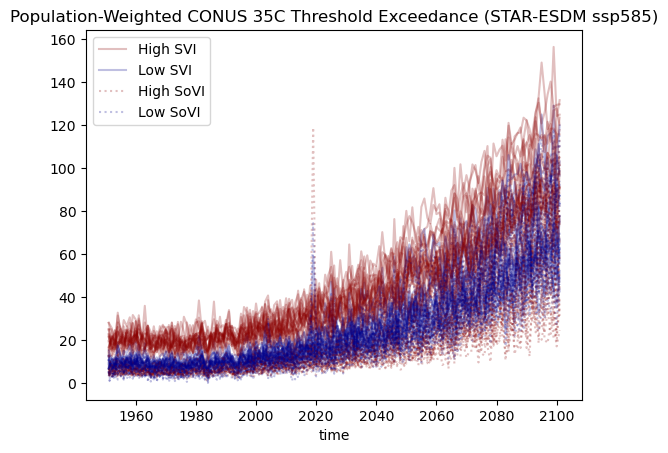

In [10]:
%%time

conus = []

high_svi = []
low_svi = []
high_sovi = []
low_sovi = []

for fi,fname in enumerate(vars()['filenames_'+str(experiment)][:-1]): ##SKIPPING TaiESM!!

    print('loading',fname)

    ds = xr.open_dataset(datadir + fname)
    model = fname.partition('.r')[0].partition('downscaled.')[2]

    for ti,temp in enumerate(temps):
        if pd.isnull(gwls[str(temp)][fi]):
            vars()['count_'+str(temp)] = ds[str(variable)][1:21,:,:].mean(dim='time')
            vars()['count_'+str(temp)] = vars()['count_'+str(temp)].where(vars()['count_'+str(temp)]>-999,'nan')
            vars()['count_'+str(temp)] = vars()['count_'+str(temp)].assign_coords(gwl=temp)
        else:
            yr = int(np.array(gwls[str(temp)][fi]))
            vars()['count_'+str(temp)] = ds[str(variable)].sel(time=slice(str(yr-9)+'-12-31',str(yr+10)+'-12-31')).mean(dim='time')
    
    # population-weight threshold exceedance over CONUS
    count_popweighted_conus = ( (ds[str(variable)] * da_pop).where(da_svi > 0).sum(dim=('longitude','latitude')) ) / (da_pop.where(da_svi > 0).sum(dim=('longitude','latitude')))
    count_popweighted_conus_highsvi = ( (ds[str(variable)] * da_pop).where(da_svi > 0.75).sum(dim=('longitude','latitude')) ) / (da_pop.where(da_svi > 0.75).sum(dim=('longitude','latitude')))
    count_popweighted_conus_lowsvi = ( (ds[str(variable)] * da_pop).where(da_svi < 0.25).sum(dim=('longitude','latitude')) ) / (da_pop.where(da_svi < 0.25).sum(dim=('longitude','latitude')))
    #SOVI
    count_popweighted_conus_highsovi = ( (ds[str(variable)] * da_pop).where(da_sovi > high_sovi_cutoff).sum(dim=('longitude','latitude')) ) / (da_pop.where(da_sovi > high_sovi_cutoff).sum(dim=('longitude','latitude')))
    count_popweighted_conus_lowsovi = ( (ds[str(variable)] * da_pop).where(da_sovi < low_sovi_cutoff).sum(dim=('longitude','latitude')) ) / (da_pop.where(da_sovi < low_sovi_cutoff).sum(dim=('longitude','latitude')))
        
    conus.append(count_popweighted_conus)
    high_svi.append(count_popweighted_conus_highsvi)
    low_svi.append(count_popweighted_conus_lowsvi)
    high_sovi.append(count_popweighted_conus_highsovi)
    low_sovi.append(count_popweighted_conus_lowsovi)

    if fi == 0:

        for ti,temp in enumerate(temps):
            vars()['allmodels_count_'+str(temp)] = vars()['count_'+str(temp)]
                
    else:
        
        for ti,temp in enumerate(temps):
            vars()['allmodels_count_'+str(temp)] = xr.concat((vars()['allmodels_count_'+str(temp)],vars()['count_'+str(temp)]),dim='model')


## print average ranges in low and high SVI areas for nClimGrid

In [11]:
lo_early = count_nclimgrid_popweighted_conus_lowsvi.sel(time=slice('1951-12-31','1980-12-31'))
hi_early = count_nclimgrid_popweighted_conus_highsvi.sel(time=slice('1951-12-31','1980-12-31'))
diff_early = hi_early - lo_early

print(thresh)

print('1951-1980 low svi median:',np.round(hi_early.median(dim='time').values,1),
      'range:', np.round(lo_early.quantile(0.05,dim='time').values.astype(np.double),1),'-',
      np.round(lo_early.quantile(0.95,dim='time').values.astype(np.double),1))

print('1951-1980 high svi median:',np.round(hi_early.median(dim='time').values,1),
      'range:', np.round(hi_early.quantile(0.05,dim='time').values.astype(np.double),1),'-',
      np.round(hi_early.quantile(0.95,dim='time').values.astype(np.double),1))

print('1951-1980 high vs low svi median:',np.round(diff_early.median(dim='time').values,1),
      'range:', np.round(diff_early.quantile(0.05,dim='time').values.astype(np.double),1),'-',
      np.round(diff_early.quantile(0.95,dim='time').values.astype(np.double),1))

U1, p = mannwhitneyu(lo_early,hi_early)
print('pvalue for high vs low in early period:',p)
print('')

lo_late = count_nclimgrid_popweighted_conus_lowsvi.sel(time=slice('1994-12-31','2023-12-31'))
hi_late = count_nclimgrid_popweighted_conus_highsvi.sel(time=slice('1994-12-31','2023-12-31'))

diff_late = hi_late - lo_late

print('1994-2023 low svi median:',np.round(hi_late.median(dim='time').values,1),
      'range:', np.round(lo_late.quantile(0.05,dim='time').values.astype(np.double),1),'-',
      np.round(lo_late.quantile(0.95,dim='time').values.astype(np.double),1))

print('1994-2023 high svi median:',np.round(hi_late.median(dim='time').values,1),
      'range:', np.round(hi_late.quantile(0.05,dim='time').values.astype(np.double),1),'-',
      np.round(hi_late.quantile(0.95,dim='time').values.astype(np.double),1))

print('1994-2023 high vs low svi median:',np.round(diff_late.median(dim='time').values,1),
      'range:', np.round(diff_late.quantile(0.05,dim='time').values.astype(np.double),1),'-',
      np.round(diff_late.quantile(0.95,dim='time').values.astype(np.double),1))

U1, p = mannwhitneyu(lo_late,hi_late)
print('pvalue for high vs low in late period:',p)
print('')


35
1951-1980 low svi median: 19.3 range: 5.8 - 15.6
1951-1980 high svi median: 19.3 range: 13.4 - 28.4
1951-1980 high vs low svi median: 11.1 range: 7.6 - 13.2
pvalue for high vs low in early period: 4.6159103691111474e-10

1994-2023 low svi median: 23.7 range: 8.0 - 16.0
1994-2023 high svi median: 23.7 range: 19.0 - 32.0
11994-2023 high vs low svi median: 13.2 range: 10.3 - 17.2
pvalue for high vs low in late period: 3.6897258539809896e-11



## for model data for high vs low SVI

In [15]:
for ti,temp in enumerate(temps[:-1]):
    
    da = vars()['allmodels_count_'+str(temp)]

    lo = ( (da * da_pop).where(da_svi < 0.25).sum(dim=('longitude','latitude')) ) / (da_pop.where(da_svi < 0.25).sum(dim=('longitude','latitude')))
    hi = ( (da * da_pop).where(da_svi > 0.75).sum(dim=('longitude','latitude')) ) / (da_pop.where(da_svi > 0.75).sum(dim=('longitude','latitude')))
    diff = hi - lo
    
    print('for',str(thresh),str(temp),'C Warming: low svi median:',np.round(lo.median(dim='model').values,1))
    print('for',str(thresh),str(temp),'C Warming: high svi median:',np.round(hi.median(dim='model').values,1))
    print('for',str(thresh),str(temp),'C Warming: high vs low svi median:',np.round(diff.median(dim='model').values,1),
         'range:', np.round(diff.quantile(0.05,dim='model').values.astype(np.double),1),'-',
          np.round(diff.quantile(0.95,dim='model').values.astype(np.double),1))
    
    print('')

for 35 1 C Warming: low svi median: 14.8
for 35 1 C Warming: high svi median: 27.9
for 35 1 C Warming: high vs low svi median: 14.1 range: 11.7 - 15.8

for 35 1.5 C Warming: low svi median: 20.5
for 35 1.5 C Warming: high svi median: 36.1
for 35 1.5 C Warming: high vs low svi median: 16.4 range: 13.1 - 18.9

for 35 2 C Warming: low svi median: 26.4
for 35 2 C Warming: high svi median: 44.8
for 35 2 C Warming: high vs low svi median: 18.7 range: 15.6 - 21.1

for 35 2.5 C Warming: low svi median: 31.4
for 35 2.5 C Warming: high svi median: 52.9
for 35 2.5 C Warming: high vs low svi median: 20.5 range: 16.8 - 23.0

for 35 3 C Warming: low svi median: 40.5
for 35 3 C Warming: high svi median: 61.9
for 35 3 C Warming: high vs low svi median: 22.3 range: 18.5 - 24.7

for 35 3.5 C Warming: low svi median: 50.4
for 35 3.5 C Warming: high svi median: 74.7
for 35 3.5 C Warming: high vs low svi median: 23.2 range: 19.8 - 26.7



In [16]:
conus_array = np.array(conus)

high_svi_array = np.array(high_svi)
low_svi_array = np.array(low_svi)


## what % of area over CONUS has threshold exceedance of X days?

In [19]:
def calc_perc_area_exceeding_latitude(data,threshold):
    # weight for global mean
    w = np.cos(np.deg2rad(data.latitude))
    w = w.broadcast_like(data)
    
    percentarea = np.round(
        (w.where(data > threshold).sum(dim=('longitude','latitude'))/w.sum(dim=('longitude','latitude'))) * 100,1)

    return percentarea


In [20]:
gwls = ['1','1.5','2','3',]
days_exceeding = 120

print(thresh,'C threshold',days_exceeding,'days')
for ti,temp in enumerate(gwls):
    da = vars()['allmodels_count_'+str(temp)].median(dim='model',skipna=True)
    print(temp,'C warming:',da.max(dim=('longitude','latitude')).values,'days at hottest location')
    print(temp,calc_perc_area_exceeding_latitude(da,days_exceeding).values,'% of CONUS exceed day threshold:',days_exceeding)
    print('')

35 C threshold 120 days
1 C warming: 168.6 days at hottest location
1 0.8 % of CONUS exceed day threshold: 120

1.5 C warming: 173.85 days at hottest location
1.5 1.1 % of CONUS exceed day threshold: 120

2 C warming: 181.6 days at hottest location
2 1.5 % of CONUS exceed day threshold: 120

3 C warming: 195.5 days at hottest location
3 2.4 % of CONUS exceed day threshold: 120



## map days/year exceeding threshold over CONUS for GLOBAL WARMING LEVELS

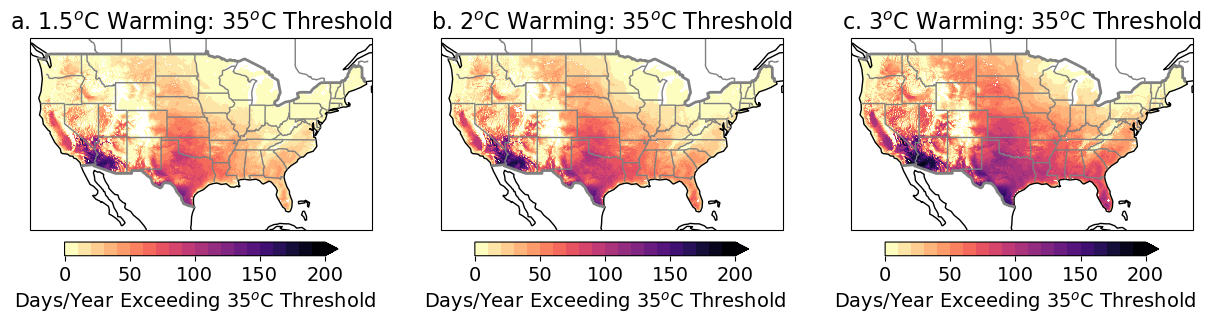

In [23]:

gwls = ['1.5','2','3',]

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cf.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

fig = plt.figure(figsize=(15,5))

extent = [-126, -66, 22, 47]

a = 1
b = 3
fsize = 16


if thresh == 35:
    panel_labs = ['a.','b.','c.']
    
    for ti,temp in enumerate(gwls):
        ax = plt.subplot(a,b,ti+1,projection = ccrs.Miller(central_longitude=0))
        ax.set_global()
        ax.coastlines(resolution='110m', linewidth=1)
        ax.set_extent(extent)
        #ax.gridlines(linestyle=':')
        ax.add_feature(cf.BORDERS,linewidth=2,color='grey')
        ax.add_feature(states_provinces, edgecolor='grey')
        plotvalue = vars()['allmodels_count_'+str(temp)].median(dim='model',skipna=True)
        plotvalue = plotvalue.where(plotvalue > 0)
        im1 = plt.pcolormesh(plotvalue.longitude,plotvalue.latitude,plotvalue,
                    cmap=plt.cm.get_cmap('magma_r',20),
                    #vmin=0, vmax=150, #0-150 for 39C threshold
                    vmin=0, vmax=200, #0-200 for 35C threshold
                    #vmin=0, vmax=280, #0-280 for 30C threshold
                    transform=ccrs.PlateCarree())
        #plt.title(str(panel_labs[ti])+' STAR-ESDM: '+str(temp)+'$^o$C \n Average Days Exceeding '+str(thresh)+'$^o$C Threshold',fontsize=fsize,ha='center')
        plt.title(str(panel_labs[ti])+' '+str(temp)+'$^o$C Warming: '+str(thresh)+'$^o$C Threshold',fontsize=fsize,ha='center')
        #cbar1=plt.colorbar(im1,ticks=np.arange(0, 500*20, 48*20),extend='max',orientation='horizontal',shrink=0.8) #plot colorbar
        cbar1=plt.colorbar(im1,extend='max',orientation='horizontal',shrink=0.8,pad=0.03) #plot colorbar
        cbar1.ax.tick_params(labelsize=fsize - 2)
        cbar1.set_label('Days/Year Exceeding '+str(thresh)+'$^o$C Threshold',fontsize=fsize - 2)



if thresh == 39:
    panel_labs = ['d.','e.','f.']
    
    for ti,temp in enumerate(gwls):
        ax = plt.subplot(a,b,ti+1,projection = ccrs.Miller(central_longitude=0))
        ax.set_global()
        ax.coastlines(resolution='110m', linewidth=1)
        ax.set_extent(extent)
        #ax.gridlines(linestyle=':')
        ax.add_feature(cf.BORDERS,linewidth=2,color='grey')
        ax.add_feature(states_provinces, edgecolor='grey')
        plotvalue = vars()['allmodels_count_'+str(temp)].median(dim='model',skipna=True)
        plotvalue = plotvalue.where(plotvalue > 0)
        im1 = plt.pcolormesh(plotvalue.longitude,plotvalue.latitude,plotvalue,
                    cmap=plt.cm.get_cmap('magma_r',20),
                    vmin=0, vmax=150, #0-150 for 39C threshold
                    #vmin=0, vmax=200, #0-200 for 35C threshold
                    #vmin=0, vmax=280, #0-280 for 30C threshold
                    transform=ccrs.PlateCarree())
        #plt.title(str(panel_labs[ti])+' STAR-ESDM: '+str(temp)+'$^o$C \n Average Days Exceeding '+str(thresh)+'$^o$C Threshold',fontsize=fsize,ha='center')
        plt.title(str(panel_labs[ti])+' '+str(temp)+'$^o$C Warming: '+str(thresh)+'$^o$C Threshold',fontsize=fsize,ha='center')
        #cbar1=plt.colorbar(im1,ticks=np.arange(0, 500*20, 48*20),extend='max',orientation='horizontal',shrink=0.8) #plot colorbar
        cbar1=plt.colorbar(im1,extend='max',orientation='horizontal',shrink=0.8,pad=0.03) #plot colorbar
        cbar1.ax.tick_params(labelsize=fsize - 2)
        cbar1.set_label('Days/Year Exceeding '+str(thresh)+'$^o$C Threshold',fontsize=fsize - 2)


## save figure
fig.savefig('figures/' + 'Figure_3_'+str(thresh)+'C', dpi=300, bbox_inches='tight')



## plot people x days/year in high-SVI areas on maps

At warming level: 1.5 : 2.27  billion people*days
At warming level: 2 : 2.79  billion people*days
At warming level: 3 : 3.89  billion people*days
colorbar max should be about: <xarray.DataArray ()> Size: 8B
array(10400058.51328125)


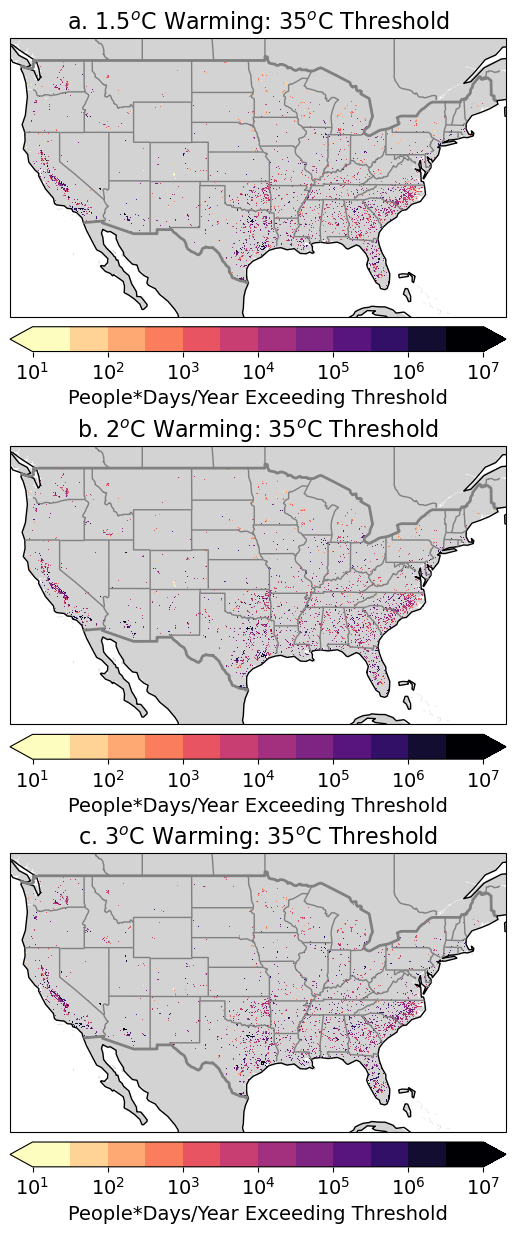

In [24]:

gwls = ['1.5','2','3',]

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cf.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

fig = plt.figure(figsize=(8,15))

extent = [-126, -66, 22, 47]

a = 3
b = 1
fsize = 16


if thresh == 35:
    panel_labs = ['a.','b.','c.']
    
    for ti,temp in enumerate(gwls):
        ax = plt.subplot(a,b,ti+1,projection = ccrs.Miller(central_longitude=0))
        ax.set_global()
        ax.add_feature(cf.LAND, zorder=0,facecolor='lightgrey') #, edgecolor='black''
        ax.coastlines(resolution='110m', linewidth=1)
        ax.set_extent(extent)
        #ax.gridlines(linestyle=':')
        ax.add_feature(cf.BORDERS,linewidth=2,color='grey')
        ax.add_feature(states_provinces, edgecolor='grey')
        plotvalue = vars()['allmodels_count_'+str(temp)].median(dim='model',skipna=True) * da_pop
        plotvalue = plotvalue.where(da_svi > 0.74)
        im1 = plt.pcolormesh(plotvalue.longitude,plotvalue.latitude,plotvalue,
                    cmap=plt.cm.get_cmap('magma_r',12),
                    norm=colors.SymLogNorm(linthresh=1, linscale=1,vmin=10, vmax=1e7,base=10),
                    transform=ccrs.PlateCarree())
        #plt.title(str(panel_labs[ti])+' STAR-ESDM: '+str(temp)+'$^o$C \n Average Days Exceeding '+str(thresh)+'$^o$C Threshold',fontsize=fsize,ha='center')
        plt.title(str(panel_labs[ti])+' '+str(temp)+'$^o$C Warming: '+str(thresh)+'$^o$C Threshold',fontsize=fsize,ha='center')
        #cbar1=plt.colorbar(im1,ticks=np.arange(0, 500*20, 48*20),extend='max',orientation='horizontal',shrink=0.8) #plot colorbar
        cbar1=plt.colorbar(im1,extend='both',orientation='horizontal',shrink=0.8,pad=0.03) #plot colorbar
        cbar1.ax.tick_params(labelsize=fsize - 2)
        cbar1.set_label('People*Days/Year Exceeding Threshold',fontsize=fsize - 2)

        print('At warming level:',str(temp),':',np.round(plotvalue.sum(dim=('longitude','latitude')).values/1e9,2),' billion people*days')

if thresh == 39:
    panel_labs = ['d.','e.','f.']
    
    for ti,temp in enumerate(gwls):
        ax = plt.subplot(a,b,ti+1,projection = ccrs.Miller(central_longitude=0))
        ax.set_global()
        ax.add_feature(cf.LAND, zorder=0,facecolor='lightgrey') #, edgecolor='black'
        ax.coastlines(resolution='110m', linewidth=1)
        ax.set_extent(extent)
        #ax.gridlines(linestyle=':')
        ax.add_feature(cf.BORDERS,linewidth=2,color='grey')
        ax.add_feature(states_provinces, edgecolor='grey')
        plotvalue = vars()['allmodels_count_'+str(temp)].median(dim='model',skipna=True) * da_pop
        plotvalue = plotvalue.where(da_svi > 0.74)
        im1 = plt.pcolormesh(plotvalue.longitude,plotvalue.latitude,plotvalue,
                    cmap=plt.cm.get_cmap('magma_r',10),
                    norm=colors.SymLogNorm(linthresh=1, linscale=1,vmin=10, vmax=1e6,base=10),
                    #vmin=0, vmax=200, #0-200 for 35C threshold
                    #vmin=0, vmax=280, #0-280 for 30C threshold
                    transform=ccrs.PlateCarree())
        #plt.title(str(panel_labs[ti])+' STAR-ESDM: '+str(temp)+'$^o$C \n Average Days Exceeding '+str(thresh)+'$^o$C Threshold',fontsize=fsize,ha='center')
        plt.title(str(panel_labs[ti])+' '+str(temp)+'$^o$C Warming: '+str(thresh)+'$^o$C Threshold',fontsize=fsize,ha='center')
        #cbar1=plt.colorbar(im1,ticks=np.arange(0, 500*20, 48*20),extend='max',orientation='horizontal',shrink=0.8) #plot colorbar
        cbar1=plt.colorbar(im1,extend='both',orientation='horizontal',shrink=0.8,pad=0.03) #plot colorbar
        cbar1.ax.tick_params(labelsize=fsize - 2)
        cbar1.set_label('People*Days/Year Exceeding Threshold',fontsize=fsize - 2)

        print('At warming level:',str(temp),':',np.round(plotvalue.sum(dim=('longitude','latitude')).values/1e9,2),' billion people*days')

## save figure
fig.savefig('figures/' + 'Figure_5_'+str(thresh)+'C_threshold_PeopleDays', dpi=300, bbox_inches='tight')

print('colorbar max should be about:',str(plotvalue.max(dim=('latitude','longitude'))))

## the same but for future population at these warming levels

At warming level: 1.5 : 3.25  billion people*days
At warming level: 2 : 4.87  billion people*days
At warming level: 3 : 8.19  billion people*days


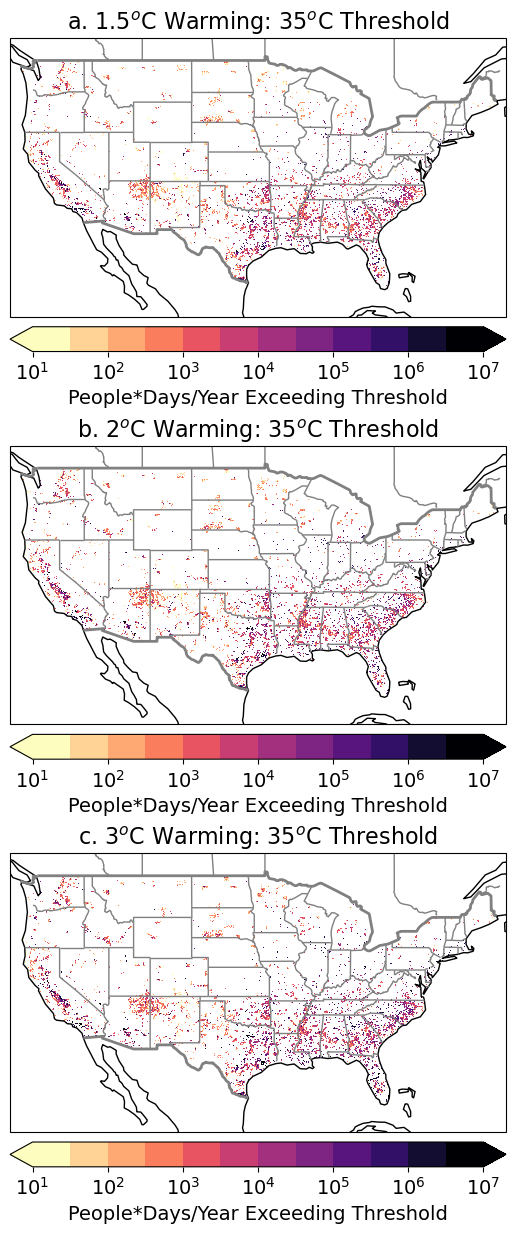

In [25]:
gwls = ['1.5','2','3',]

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cf.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

fig = plt.figure(figsize=(8,15))

extent = [-126, -66, 22, 47]

a = 3
b = 1
fsize = 16


if thresh == 35:
    panel_labs = ['a.','b.','c.']
    
    for ti,temp in enumerate(gwls):
        ax = plt.subplot(a,b,ti+1,projection = ccrs.Miller(central_longitude=0))
        ax.set_global()
        ax.coastlines(resolution='110m', linewidth=1)
        ax.set_extent(extent)
        #ax.gridlines(linestyle=':')
        ax.add_feature(cf.BORDERS,linewidth=2,color='grey')
        ax.add_feature(states_provinces, edgecolor='grey')
        if '1.5' in temp:
            plotvalue = vars()['allmodels_count_'+str(temp)].median(dim='model',skipna=True) * popw_allyears.sel(time='2032-12-31')
        if '2' in temp:
            plotvalue = vars()['allmodels_count_'+str(temp)].median(dim='model',skipna=True) * popw_allyears.sel(time='2050-12-31')
        if '3' in temp:
            plotvalue = vars()['allmodels_count_'+str(temp)].median(dim='model',skipna=True) * popw_allyears.sel(time='2069-12-31')           
        plotvalue = plotvalue.where(da_svi > 0.74)
        im1 = plt.pcolormesh(plotvalue.longitude,plotvalue.latitude,plotvalue,
                    cmap=plt.cm.get_cmap('magma_r',12),
                    norm=colors.SymLogNorm(linthresh=1, linscale=1,vmin=10, vmax=1e7,base=10),
                    transform=ccrs.PlateCarree())
        #plt.title(str(panel_labs[ti])+' STAR-ESDM: '+str(temp)+'$^o$C \n Average Days Exceeding '+str(thresh)+'$^o$C Threshold',fontsize=fsize,ha='center')
        plt.title(str(panel_labs[ti])+' '+str(temp)+'$^o$C Warming: '+str(thresh)+'$^o$C Threshold',fontsize=fsize,ha='center')
        #cbar1=plt.colorbar(im1,ticks=np.arange(0, 500*20, 48*20),extend='max',orientation='horizontal',shrink=0.8) #plot colorbar
        cbar1=plt.colorbar(im1,extend='both',orientation='horizontal',shrink=0.8,pad=0.03) #plot colorbar
        cbar1.ax.tick_params(labelsize=fsize - 2)
        cbar1.set_label('People*Days/Year Exceeding Threshold',fontsize=fsize - 2)

        print('At warming level:',str(temp),':',np.round(plotvalue.sum(dim=('longitude','latitude')).values/1e9,2),' billion people*days')

if thresh == 39:
    panel_labs = ['d.','e.','f.']
    
    for ti,temp in enumerate(gwls):
        ax = plt.subplot(a,b,ti+1,projection = ccrs.Miller(central_longitude=0))
        ax.set_global()
        ax.coastlines(resolution='110m', linewidth=1)
        ax.set_extent(extent)
        #ax.gridlines(linestyle=':')
        ax.add_feature(cf.BORDERS,linewidth=2,color='grey')
        ax.add_feature(states_provinces, edgecolor='grey')
        if '1.5' in temp:
            plotvalue = vars()['allmodels_count_'+str(temp)].median(dim='model',skipna=True) * popw_allyears.sel(time='2032-12-31')
        if '2' in temp:
            plotvalue = vars()['allmodels_count_'+str(temp)].median(dim='model',skipna=True) * popw_allyears.sel(time='2050-12-31')
        if '3' in temp:
            plotvalue = vars()['allmodels_count_'+str(temp)].median(dim='model',skipna=True) * popw_allyears.sel(time='2069-12-31')           
        plotvalue = plotvalue.where(da_svi > 0.74)
        im1 = plt.pcolormesh(plotvalue.longitude,plotvalue.latitude,plotvalue,
                    cmap=plt.cm.get_cmap('magma_r',10),
                    norm=colors.SymLogNorm(linthresh=1, linscale=1,vmin=10, vmax=1e6,base=10),
                    #vmin=0, vmax=200, #0-200 for 35C threshold
                    #vmin=0, vmax=280, #0-280 for 30C threshold
                    transform=ccrs.PlateCarree())
        #plt.title(str(panel_labs[ti])+' STAR-ESDM: '+str(temp)+'$^o$C \n Average Days Exceeding '+str(thresh)+'$^o$C Threshold',fontsize=fsize,ha='center')
        plt.title(str(panel_labs[ti])+' '+str(temp)+'$^o$C Warming: '+str(thresh)+'$^o$C Threshold',fontsize=fsize,ha='center')
        #cbar1=plt.colorbar(im1,ticks=np.arange(0, 500*20, 48*20),extend='max',orientation='horizontal',shrink=0.8) #plot colorbar
        cbar1=plt.colorbar(im1,extend='both',orientation='horizontal',shrink=0.8,pad=0.03) #plot colorbar
        cbar1.ax.tick_params(labelsize=fsize - 2)
        cbar1.set_label('People*Days/Year Exceeding Threshold',fontsize=fsize - 2)

        print('At warming level:',str(temp),':',np.round(plotvalue.sum(dim=('longitude','latitude')).values/1e9,2),' billion people*days')

# save figure
fig.savefig('figures/' + 'Figure_5_'+str(thresh)+'C_threshold_PeopleDays_WorldPop_DYNAMIC_'+str(ssp_pop), dpi=300, bbox_inches='tight')



## plot violin plots at various warming levels

In [26]:

for ti,temp in enumerate(temps):
    
    da = vars()['allmodels_count_'+str(temp)]
        
    vars()['conus_allmodels_count_'+str(temp)] = ( (da * da_pop).where(da_states<4000).sum(dim=('longitude','latitude')) ) / (da_pop.where(da_states<4000).sum(dim=('longitude','latitude')))
    vars()['conus_hi_allmodels_count_'+str(temp)] =  ( (da * da_pop).where(da_svi > 0.75).sum(dim=('longitude','latitude')) ) / (da_pop.where(da_svi > 0.75).sum(dim=('longitude','latitude')))
    vars()['conus_lo_allmodels_count_'+str(temp)]  = ( (da * da_pop).where(da_svi < 0.25).sum(dim=('longitude','latitude')) ) / (da_pop.where(da_svi < 0.25).sum(dim=('longitude','latitude')))


In [29]:
# creating a list of index names
index_values = ['Low SVI','High-SVI']
   
# creating a list of column names
column_values = models #
  
length_obs = 30
nmodels = len(vars()['conus_lo_allmodels_count_1.5'])


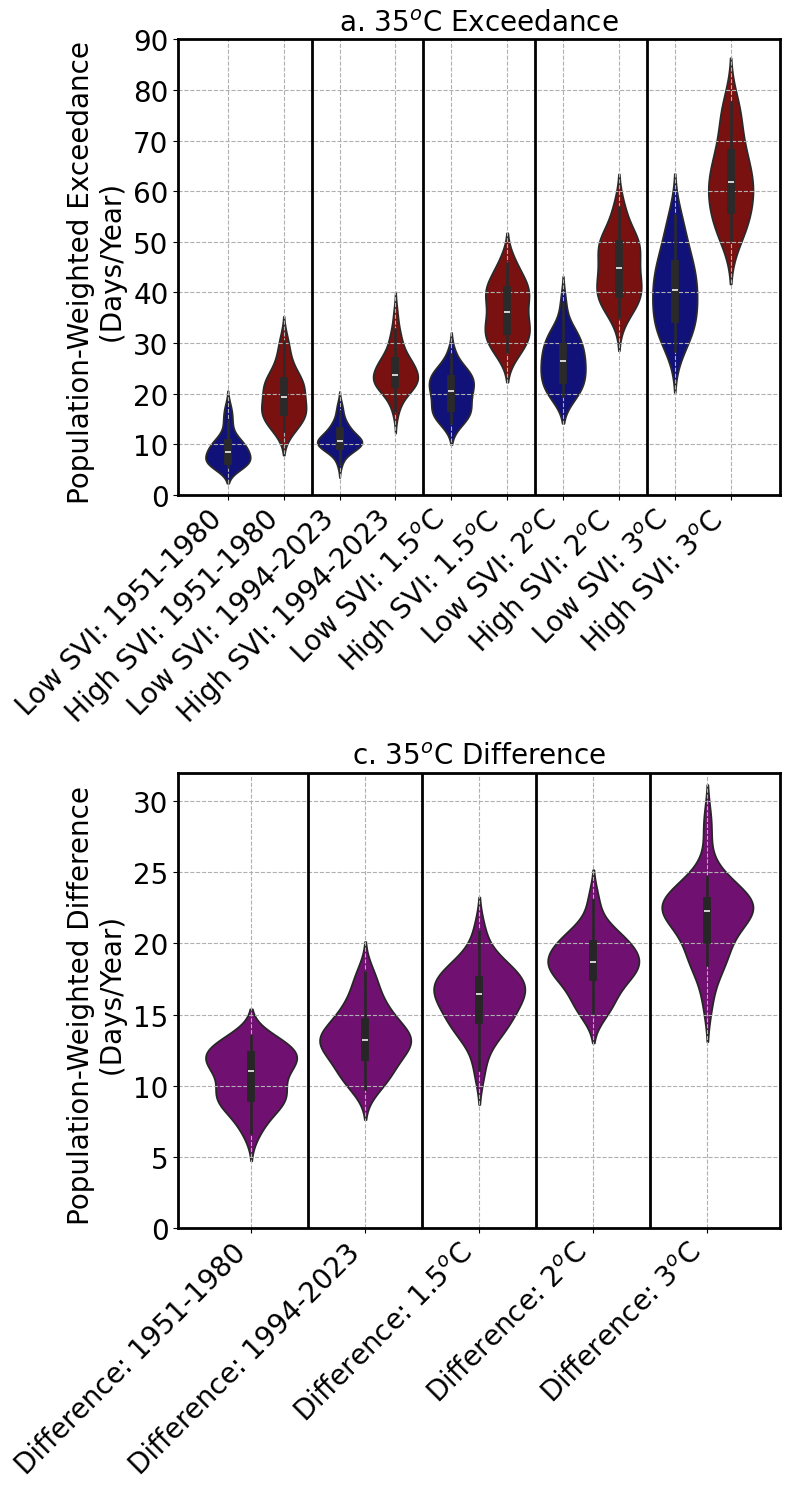

In [32]:
df = pd.DataFrame({'Low SVI: 1951-1980': count_nclimgrid_popweighted_conus_lowsvi.sel(time=slice('1951-12-31','1980-12-31')),
                   'High SVI: 1951-1980': count_nclimgrid_popweighted_conus_highsvi.sel(time=slice('1951-12-31','1980-12-31')),
                   'Low SVI: 1994-2023': count_nclimgrid_popweighted_conus_lowsvi.sel(time=slice('1994-12-31','2023-12-31')),
                   'High SVI: 1994-2023': count_nclimgrid_popweighted_conus_highsvi.sel(time=slice('1994-12-31','2023-12-31')),
                   'Low SVI: 1.5$^o$C': np.concat((vars()['conus_lo_allmodels_count_1.5'], [np.nan]*(length_obs - nmodels))),
                   'High SVI: 1.5$^o$C': np.concat((vars()['conus_hi_allmodels_count_1.5'], [np.nan]*(length_obs - nmodels))),
                   'Low SVI: 2$^o$C': np.concat((vars()['conus_lo_allmodels_count_2'], [np.nan]*(length_obs - nmodels))),
                   'High SVI: 2$^o$C': np.concat((vars()['conus_hi_allmodels_count_2'], [np.nan]*(length_obs - nmodels))),
                   'Low SVI: 3$^o$C': np.concat((vars()['conus_lo_allmodels_count_3'], [np.nan]*(length_obs - nmodels))),
                   'High SVI: 3$^o$C': np.concat((vars()['conus_hi_allmodels_count_3'], [np.nan]*(length_obs - nmodels))),
                  })

my_pal = {"Low SVI: 1951-1980": "darkblue",
          "High SVI: 1951-1980": "darkred",
         "Low SVI: 1994-2023": "darkblue",
          "High SVI: 1994-2023": "darkred",
         "Low SVI: 1.5$^o$C": "darkblue",
          "High SVI: 1.5$^o$C": "darkred",
         "Low SVI: 2$^o$C": "darkblue",
          "High SVI: 2$^o$C": "darkred",
         "Low SVI: 3$^o$C": "darkblue",
          "High SVI: 3$^o$C": "darkred",}


fsize = 20

fig = plt.figure(figsize=(8,15))

ax = plt.subplot(2,1,1)
sns.violinplot(ax=ax,data=df,palette=my_pal)

if thresh == 35:
    plt.title('a. '+str(thresh)+'$^o$C Exceedance',fontsize=fsize)
if thresh == 39:
    plt.title('b. '+str(thresh)+'$^o$C Exceedance',fontsize=fsize)

#plt.xlim([1950,2021])
plt.ylabel('Population-Weighted Exceedance \n (Days/Year)',fontsize=fsize)

ax.tick_params(axis='x', which='major', labelsize=fsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', va='top')


if thresh == 39:
    plt.ylim([1,34])
    plt.vlines(1.5,0,35,linewidth = 2, color='k', linestyle='-')
    plt.vlines(3.5,0,35,linewidth = 2, color='k', linestyle='-')
if thresh == 35:
    plt.ylim([0,90])
    plt.vlines(1.5,0,90,linewidth = 2, color='k', linestyle='-')
    plt.vlines(3.5,0,90,linewidth = 2, color='k', linestyle='-')
    plt.vlines(5.5,0,90,linewidth = 2, color='k', linestyle='-')
    plt.vlines(7.5,0,90,linewidth = 2, color='k', linestyle='-')

    plt.yticks(fontsize=fsize)
#plt.legend(fontsize=fsize)
plt.grid(linestyle='--')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
plt.tight_layout()



########## NOW DIFFERENCE IN SAME FIGURE

df = pd.DataFrame({'Difference: 1951-1980': count_nclimgrid_popweighted_conus_highsvi.sel(time=slice('1951-12-31','1980-12-31')) - count_nclimgrid_popweighted_conus_lowsvi.sel(time=slice('1951-12-31','1980-12-31')),
                   'Difference: 1994-2023': count_nclimgrid_popweighted_conus_highsvi.sel(time=slice('1994-12-31','2023-12-31')) - count_nclimgrid_popweighted_conus_lowsvi.sel(time=slice('1994-12-31','2023-12-31')),
                   'Difference: 1.5$^o$C': np.concat((vars()['conus_hi_allmodels_count_1.5'] - vars()['conus_lo_allmodels_count_1.5'], [np.nan]*(length_obs - nmodels))),
                   'Difference: 2$^o$C': np.concat((vars()['conus_hi_allmodels_count_2'] - vars()['conus_lo_allmodels_count_2'], [np.nan]*(length_obs - nmodels))),
                   'Difference: 3$^o$C': np.concat((vars()['conus_hi_allmodels_count_3'] - vars()['conus_lo_allmodels_count_3'], [np.nan]*(length_obs - nmodels))),
                  })


my_pal = {"Difference: 1951-1980": "purple",
          "Difference: 1994-2023": "purple",
          "Difference: 1.5$^o$C": "purple",
          "Difference: 2$^o$C": "purple",
          "Difference: 3$^o$C": "purple",}


ax = plt.subplot(2,1,2)
sns.violinplot(ax=ax,data=df,palette=my_pal)

if thresh == 35:
    plt.title('c. '+str(thresh)+'$^o$C Difference',fontsize=fsize)
if thresh == 39:
    plt.title('d. '+str(thresh)+'$^o$C Difference',fontsize=fsize)

#plt.xlim([1950,2021])
plt.ylabel('Population-Weighted Difference \n (Days/Year)',fontsize=fsize)

ax.tick_params(axis='x', which='major', labelsize=fsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', va='top')


if thresh == 39:
    plt.ylim([0,17])
    plt.vlines(0.5,0,17,linewidth = 2, color='k', linestyle='-')
    plt.vlines(1.5,0,17,linewidth = 2, color='k', linestyle='-')
if thresh == 35:
    plt.ylim([0,32])
    plt.vlines(0.5,0,32,linewidth = 2, color='k', linestyle='-')
    plt.vlines(1.5,0,32,linewidth = 2, color='k', linestyle='-')
    plt.vlines(2.5,0,32,linewidth = 2, color='k', linestyle='-')
    plt.vlines(3.5,0,32,linewidth = 2, color='k', linestyle='-')
        
plt.yticks(fontsize=fsize)
#plt.legend(fontsize=fsize)
plt.grid(linestyle='--')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
plt.tight_layout()

#save figure
fig.savefig('figures/' + 'Figure_4_'+str(thresh)+'C_Threshold_ViolinPlots_WarmingLevels', dpi=300, bbox_inches='tight')

